In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_selection import VarianceThreshold
from datetime import date

In [2]:
tutorial = pd.read_csv("data/brazil_tutorial.csv")

/home/users/s17011720/.conda/envs/jupyter/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (0,1,2,59) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
tutorial.shape

(1008752, 89)

In [4]:
from difflib import SequenceMatcher
def similar(a, b):
    match_score = SequenceMatcher(None, a, b).ratio()
    if match_score == 1.0:
        result = "Full Match"
    elif match_score >= .85:
        result = "Partial Match"
    else:
        result = "No Match"
    return result 

### tutorial ad_id 보간

- event_params_ad_id, user_properties_ad_id 합집합
- user_pseudo_id

In [7]:
# ad_id 
match_score = SequenceMatcher(None, tutorial.event_params_ad_id, tutorial.user_properties_ad_id).ratio()
match_score

0.999936555268292

In [5]:
tutorial[['event_params_ad_id', 'user_properties_ad_id']].isnull().sum()

event_params_ad_id       9194
user_properties_ad_id    9256
dtype: int64

In [8]:
print('user_properties_ad_id : {}명'.format(len(tutorial['user_properties_ad_id'].unique())))
print('event_params_ad_id : {}명'.format(len(tutorial['event_params_ad_id'].unique())))

user_properties_ad_id : nan 포함 243265명
event_params_ad_id : nan 포함 243282명


In [5]:
params_ad_id_null = tutorial[tutorial['event_params_ad_id'].isnull()]
params_ad_id_null_idx = params_ad_id_null.index

In [6]:
params_ad_id_null['user_properties_ad_id'].unique()

array([nan, '900cd2b1-253b-408c-ab6c-cb26234cdc38'], dtype=object)

In [7]:
tutorial.loc[params_ad_id_null_idx, 'event_params_ad_id'] = tutorial.loc[params_ad_id_null_idx, 'user_properties_ad_id']

In [8]:
tutorial.drop('user_properties_ad_id', axis=1, inplace=True)

In [9]:
tutorial.rename(columns={'event_params_ad_id': 'ad_id'}, inplace=True)

In [10]:
len(tutorial['ad_id'].unique())

243282

In [14]:
tutorial[tutorial['ad_id'].isnull() & ~(tutorial['user_pseudo_id'].isnull())].shape

(9193, 88)

In [13]:
pseudo_df[['ad_id', 'user_pseudo_id']]

,ad_id,user_pseudo_id
290,NaN,bd578b1bf3a8363a5c9b0044254d5a82
343,NaN,aecf7f568bae32708c77fce79dda7957
345,NaN,8a5f234c1669a2bc20d15ae6db605b5b
1243,NaN,470a86721e1b228631e499f3e0e9d447
1254,NaN,917baccf435c03ea181058c9e9b5557a
...,...,...
1008504,NaN,cb3adc32949db59ee82c7b6b53668723
1008507,NaN,cb3adc32949db59ee82c7b6b53668723
1008635,NaN,9d8c7ab5f707719f1d3365372188c512
1008639,NaN,5071dbae545207708edafccf41789be8


### target selection 
- tutorial을 모두 완료한 user: tutorial_id = 1,2,3,4 포함
- 신규가입자: 'event_previous_timestamp' == np.nan
- day7 까지 데이터가 있는 user: 첫 접속일이 데이터의 마지막날의 일주일 전보다 나중인 user 제거 ex) 0101 ~ 0130 → 0101 ~ 0123 ⇒ 0124에 들어온 user가 day 7 이 있을 수가 없기 때문.

## 1. 쓸 데 없는 컬럼 제거

In [15]:
def drop_na_columns(df, percentage):
    missing_values_count = df.isnull().sum()
    # 데이터 세트의 값 중 몇 퍼센트가 누락되었는지 확인
    total_cells = np.product(df.shape)
    total_missing = missing_values_count.sum()

    (total_missing/total_cells) * 100

    # Percentage of NAN Values 
    NAN = [(c, df[c].isna().mean()*100) for c in df]
    NAN = pd.DataFrame(NAN, columns=["column_name", "percentage"])

    # Features with more than 50% of missing values.
    NAN = NAN[NAN.percentage > percentage]
    # NAN.sort_values("percentage", ascending=False)

    NAN_cols = NAN['column_name'].to_list()
    df_dropped_na = df.drop(NAN_cols,axis=1)
    print('Number of dropped columns', df.shape[1] - df_dropped_na.shape[1])
    
    return df_dropped_na

def drop_col_not_using(df):

    firebase_col = [s for s in df.columns if "firebase" in s]
    df_dropped_na = df.drop(firebase_col, axis=1)
    
    df_col = df_dropped_na.columns
    duplicated_col = [s for s in df_col if "_1" in s]
#     app_info_col = [s for s in df_col if "app_info" in s]
#     device_col = [s for s in df_col if "device" in s]
#     traffic_col = [s for s in df_col if "traffic" in s]
#     geo_col = [s for s in df_col if "geo" in s]
    # user_col =  [s for s in df_col if "user" in s]

    df_dropped_na.drop(duplicated_col, axis=1, inplace=True)
#     df_dropped_na.drop(app_info_col, axis=1, inplace=True)
#     df_dropped_na.drop(device_col, axis=1, inplace=True)
#     df_dropped_na.drop(traffic_col, axis=1, inplace=True)
#     df_dropped_na.drop(geo_col, axis=1, inplace=True)
    print('Number of dropped columns', df.shape[1] - df_dropped_na.shape[1])
    
    return df_dropped_na

In [16]:
tut_filtered = drop_na_columns(tutorial, 50)
tut_filtered.shape

Number of dropped columns 18


(1008752, 70)

In [17]:
tut_filtered = drop_col_not_using(tut_filtered)
tut_filtered.shape

Number of dropped columns 20


(1008752, 50)

In [18]:
tut_filtered.columns

Index(['traffic_source_medium', 'traffic_source_source', 'traffic_source_name',
       'event_date', 'event_timestamp', 'event_name', 'ad_id', 'ga_session_id',
       'engaged_session_event', 'tutorial_name', 'ga_session_number',
       'tutorial_id', 'event_previous_timestamp', 'event_bundle_sequence_id',
       'event_server_timestamp_offset', 'user_pseudo_id',
       'ga_session_number_timestamp', 'ad_id_timestamp', 'cuid',
       'cuid_timestamp', 'frist_version', 'frist_version_timestamp',
       'user_level', 'user_level_timestamp', 'first_open_time',
       'first_open_time_timestamp', 'ga_session_id_timestamp',
       'user_first_touch_timestamp', 'device_category',
       'device_mobile_brand_name', 'mobile_model_name',
       'device_mobile_os_hardware_model', 'device_operating_system',
       'device_operating_system_version', 'device_advertising_id',
       'device_language', 'device_is_limited_ad_tracking',
       'device_time_zone_offset_seconds', 'geo_continent', 'geo_co

- 분산 확인

In [19]:
# 숫자형 columns명 저장
col = tut_filtered.corr().columns 
df_num = tut_filtered[col].copy()

In [20]:
df_num.fillna(-1, inplace=True)
len(col)

22

In [21]:
# Check for presence of Null features
[col for col in df_num.columns if df_num[col].isnull().sum() > 0]

[]

In [22]:
feature_selector = VarianceThreshold(threshold=0.1)
feature_selector.fit(df_num)

VarianceThreshold(threshold=0.1)

In [23]:
lowvar_col = [x for x in df_num.columns if x not in df_num.columns[feature_selector.get_support()]]
df = df_num[lowvar_col]

In [24]:
tut_filtered['engaged_session_event'].unique()

array([ 1., nan])

In [25]:
tut_filtered['ga_session_number'].unique()

array([ 1.,  3.,  2.,  4.,  5.,  6., nan, 13.,  7., 10., 11., 14., 12.,
        9., 15., 17., 18.])

In [26]:
tut_filtered['device_is_limited_ad_tracking'].unique()

array([False,  True])

In [27]:
tut_filtered['stream_id'].unique()

array([2205916636])

In [28]:
tut_filtered.drop('stream_id', axis=1, inplace=True)

<AxesSubplot:>

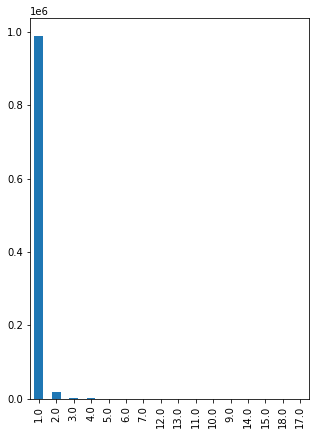

In [29]:
tut_filtered['ga_session_number'].value_counts().plot(kind='bar',figsize=[5,7])

<AxesSubplot:>

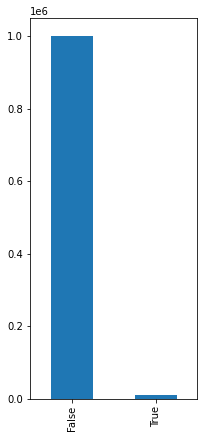

In [30]:
tut_filtered['device_is_limited_ad_tracking'].value_counts().plot(kind='bar',figsize=[3,7])

In [31]:
len(tut_filtered[tut_filtered['ad_id'].isnull() & (tut_filtered['device_is_limited_ad_tracking']==False)])

32

In [32]:
tut_filtered[~tut_filtered['ad_id'].isnull() & (tut_filtered['device_is_limited_ad_tracking']==True)]

,traffic_source_medium,traffic_source_source,traffic_source_name,event_date,event_timestamp,event_name,ad_id,ga_session_id,engaged_session_event,tutorial_name,...,geo_country,geo_region,geo_city,geo_sub_continent,geo_metro,app_info_id,app_info_version,app_info_install_source,platform,items
702653,organic,google-play,NaN,20210410,1618090639623000,tutorial,900cd2b1-253b-408c-ab6c-cb26234cdc38,1.618091e+09,1.0,stage_end,...,Brazil,State of Minas Gerais,Belo Horizonte,South America,(not set),kr.co.DrawHammer1,1.5.0,com.android.vending,ANDROID,[]


In [33]:
cant_tracking = tut_filtered[tut_filtered['device_is_limited_ad_tracking']==True]
cant_tracking_id = cant_tracking['ad_id'].unique()
cant_tracking_id

array([nan, '900cd2b1-253b-408c-ab6c-cb26234cdc38'], dtype=object)

In [36]:
# cant_tracking_id.remove('nan')
cant_tracking_id = np.delete(cant_tracking_id, 0)
cant_tracking_id

array(['900cd2b1-253b-408c-ab6c-cb26234cdc38'], dtype=object)

'device_is_limited_ad_tracking': 광고 추척에 제한있는 디바이스를 구분하는  컬럼 (True/ False)

→ True: 9162row  대부분의 ad_id 가 nan 값을 가짐 ⇒ 빼는 것이 좋을 것 같다.

In [37]:
cant_tracking_idx = cant_tracking.index
tut_filtered.drop(cant_tracking_idx, inplace=True)

In [38]:
cant_tracking_idx = tut_filtered[tut_filtered['ad_id'].isin(cant_tracking_id)].index
tut_filtered.drop(cant_tracking_idx, inplace=True)
tut_filtered.reset_index(drop=True, inplace=True)

In [39]:
tut_filtered['ad_id'].isnull().sum()

32

## 2. tutorial을 모두 완료한 user
: tutorial_id = 1,2,3,4 포함

In [40]:
tut_filtered.shape

(999587, 49)

In [41]:
df = pd.DataFrame(tut_filtered.groupby('ad_id')['tutorial_id'].size())
# df

In [42]:
not_clear_tut_id = df[df['tutorial_id'] < 4].index

In [43]:
not_clear_tut_idx = tut_filtered[tut_filtered['ad_id'].isin(not_clear_tut_id)].index
tut_filtered.drop(not_clear_tut_idx, axis=0, inplace=True)

In [44]:
tut_filtered.shape

(995337, 49)

In [45]:
clear_list = [1,2,3,4]

In [49]:
grp = tut_filtered.groupby('ad_id')
not_clear_df = grp.filter(lambda x : all(~x['tutorial_id'].isin(clear_list)))
not_clear_df

,traffic_source_medium,traffic_source_source,traffic_source_name,event_date,event_timestamp,event_name,ad_id,ga_session_id,engaged_session_event,tutorial_name,...,geo_country,geo_region,geo_city,geo_sub_continent,geo_metro,app_info_id,app_info_version,app_info_install_source,platform,items


## 3. 신규가입자
: 'event_previous_timestamp' == np.nan

In [54]:
len(tut_filtered['ad_id'].unique())

241345

In [67]:
len(tut_filtered[tut_filtered['event_previous_timestamp'].isnull()]['ad_id'].unique())

241344

In [56]:
grp = tut_filtered.groupby('ad_id')
not_new_df = grp.filter(lambda x : all(x['event_previous_timestamp'] != np.nan))
not_new_df.head()

,traffic_source_medium,traffic_source_source,traffic_source_name,event_date,event_timestamp,event_name,ad_id,ga_session_id,engaged_session_event,tutorial_name,...,geo_country,geo_region,geo_city,geo_sub_continent,geo_metro,app_info_id,app_info_version,app_info_install_source,platform,items
0,NaN,NaN,NaN,20210417,1618716504567000,tutorial,8c1573e7-f440-431e-b516-00c5b621fd63,1.618716e+09,1.0,draw_start,...,Brazil,State of Sao Paulo,Sao Paulo,South America,(not set),kr.co.DrawHammer1,1.5.1,com.android.vending,ANDROID,[]
1,NaN,NaN,NaN,20210410,1618080730037000,tutorial,1d1ec878-3d36-46e5-a2cc-3bed46341679,1.618081e+09,1.0,stage_end,...,Brazil,State of Amapa,Macapa,South America,(not set),kr.co.DrawHammer1,1.5.0,com.android.vending,ANDROID,[]
2,NaN,NaN,NaN,20210413,1618362123481000,tutorial,95511509-8065-4227-bd5a-a803ddbed7b6,1.618362e+09,1.0,draw_end,...,Brazil,State of Pernambuco,NaN,South America,(not set),kr.co.DrawHammer1,1.5.1,com.android.vending,ANDROID,[]
3,NaN,NaN,NaN,20210416,1618572315366000,tutorial,a42b11cd-da75-4043-897f-18c3f4d67c3e,1.618572e+09,1.0,stage_end,...,Brazil,State of Minas Gerais,Patos de Minas,South America,(not set),kr.co.DrawHammer1,1.5.1,com.android.vending,ANDROID,[]
4,NaN,NaN,NaN,20210419,1618892539702000,tutorial,c1fb8a47-9bbb-4faa-935d-d533b985431a,1.618892e+09,1.0,draw_end,...,Brazil,State of Sao Paulo,Sao Paulo,South America,(not set),kr.co.DrawHammer1,1.5.2,com.android.vending,ANDROID,[]


In [57]:
new_user.shape

(995305, 49)

In [58]:
len(new_user['ad_id'].unique())

241344

## 4. day7 까지 데이터가 있는 user
: 첫 접속일이 데이터의 마지막날의 8일 전보다 나중인 user 제거 ex) 0101 ~ 0130 → 0101 ~ 0123 ⇒ 0124에 들어온 user가 day 7 이 있을 수가 없기 때문.

In [76]:
new_user.columns

Index(['traffic_source_medium', 'traffic_source_source', 'traffic_source_name',
       'event_date', 'event_timestamp', 'event_name', 'ad_id', 'ga_session_id',
       'engaged_session_event', 'tutorial_name', 'ga_session_number',
       'tutorial_id', 'event_previous_timestamp', 'event_bundle_sequence_id',
       'event_server_timestamp_offset', 'user_pseudo_id',
       'ga_session_number_timestamp', 'ad_id_timestamp', 'cuid',
       'cuid_timestamp', 'frist_version', 'frist_version_timestamp',
       'user_level', 'user_level_timestamp', 'first_open_time',
       'first_open_time_timestamp', 'ga_session_id_timestamp',
       'user_first_touch_timestamp', 'device_category',
       'device_mobile_brand_name', 'mobile_model_name',
       'device_mobile_os_hardware_model', 'device_operating_system',
       'device_operating_system_version', 'device_advertising_id',
       'device_language', 'device_is_limited_ad_tracking',
       'device_time_zone_offset_seconds', 'geo_continent', 'geo_co

In [116]:
event_datetime = pd.to_datetime(new_user['event_timestamp'], unit='us')
new_user.loc[:, 'event_datetime'] = event_datetime

In [132]:
print('datetime period: {} ~ {}'.format(new_user['event_datetime'].dt.date.min(), new_user['event_datetime'].dt.date.max()))

datetime period: 2021-04-01 ~ 2021-05-16


In [119]:
new_user['event_datetime'].max()

Timestamp('2021-05-16 03:50:12.177000')

In [141]:
# limited_date_df = new_user[new_user['event_datetime'].dt.date < date.fromisoformat('2021-05-09')]
# limited_date_df.reset_index(drop=True, inplace=True)
# limited_date_df.shape # (993581, 50)
# len(limited_date_df['ad_id'].unique()) # 241030

(993581, 50)

In [147]:
limit_date = date.fromisoformat('2021-05-09')

grp = new_user.groupby('ad_id')
limited_date_df = grp.filter(lambda x : all(x['event_datetime'].dt.date < limit_date))

In [148]:
limited_date_df.shape

(993059, 50)

In [149]:
len(limited_date_df['ad_id'].unique())

240911

In [150]:
limited_date_df['event_datetime'].max()

Timestamp('2021-05-08 23:51:48.059000')

In [151]:
limited_date_df.to_csv('tutorial_filtered.csv', index = False)